In [24]:
from tes.data import Data,PacketStream,Packet,Payload,EventFlags
from tes.hdf5 import _PacketData, _import
import numpy as np
import matplotlib.pyplot as plt
from subprocess import Popen

import logging
import sys
logger = logging.getLogger('tes')
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s:%(levelname)s %(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

trace_dt=np.dtype([('f','i4'),('s','i4')])
min_dt=np.dtype([
    ('clk','i4'),('f','i4'),('s','i4'),('low','i4'),('high','i4'),('flags','i4'),
    ('max_slope','i4')
])
max_dt=np.dtype([
    ('clk','i4'),('f','i4'),('s','i4'),('flags','i4')
])

xing_dtype=np.dtype([('clk','i4')])

def xings(s, thresh):
    xing = np.zeros_like(s)
    i=0
    was_above = s[0] > thresh
    for i in range(1, len(s)):
        if s[i] > thresh:
            if not was_above:
                xing[i] = 1
            was_above = True
        if s[i] < thresh:
            if was_above:
                xing[i] = -1
            was_above = False
            
    return np.where(xing==1)[0], np.where(xing==-1)[0]


In [195]:
traces=Data.fromfile('traces',trace_dt,'teslib','CFD_TB',tool='vivado')
min_data=Data.fromfile('min_data',min_dt,'teslib','CFD_TB',tool='vivado')
max_data=Data.fromfile('max_data',max_dt,'teslib','CFD_TB',tool='vivado')
low_xing=Data.fromfile('low_data',xing_dt,'teslib','CFD_TB',tool='vivado')
high_xing=Data.fromfile('high_data',xing_dt,'teslib','CFD_TB',tool='vivado')
f=traces['f']
s=traces['s']

In [198]:
pthresh=0
sthresh=0
cf=(pow(2,17)//5)
if maxs[0] < mins[0]:
    maxs = maxs[1:] #start with a min
for i in range(len(min_data)):
    mi = min_data['clk'][i]
    flags=np.unpackbits(min_data['flags'][i].astype(np.uint8))
    if mins[i] != mi:
        print('index mismatch',i)
        break
    maxima = f[maxs[i]]
    minima = f[mins[i]]
    if min_data['f'][i]!=minima:
        print('minima mismatch',min_data['f'],min,i)
    
    if minima <= pthresh: # first rise
        if flags[1] == 0:
            print('expected first rise',f[mins[i]],flags,i)
            break
        cfi = f[maxs[i]]*cf
        cf_min = 0
        
    else: # not first rise
        if flags[1] == 1:
            print('unexpected first rise',f[mins[i]],flags,i)
            break
        cf_min = minima
        cfi = (maxima-minima)*cf
        
    cfi_f,_ = np.modf(cfi)
    cfi_i = np.right_shift(cfi,17)
#     if np.abs(cfi_f) >= 0.5:
#         cfi_i= int(cfi_i)+np.sign(cfi)
    high = maxima-cfi_i
    low= cf_min+cfi_i
    
#         p=(f[maxs[i]]-f[mins[i]]
    if min_data['high'][i] != high:
        print('high mismatch',maxima,min_data['high'][i],high,cfi_i,i)
    if min_data['low'][i] != low:
        print('low mismatch',minima,min_data['low'][i],low,cfi_i,i)
    
    if low < minima:
        if flags[6] != 1:
            print('expected cfd_error',i)
    else:
        if flags[6] == 1:
            print('unexpected cfd_error',i)
        
    

unexpected cfd_error 0
unexpected cfd_error 2
unexpected cfd_error 3
unexpected cfd_error 4
unexpected cfd_error 16
unexpected cfd_error 17
unexpected cfd_error 19
unexpected cfd_error 24
unexpected cfd_error 26
unexpected cfd_error 28
unexpected cfd_error 29
unexpected cfd_error 30
unexpected cfd_error 32
unexpected cfd_error 41
unexpected cfd_error 45
unexpected cfd_error 47
unexpected cfd_error 48
unexpected cfd_error 57
unexpected cfd_error 62
unexpected cfd_error 63
unexpected cfd_error 65
unexpected cfd_error 66
unexpected cfd_error 69
unexpected cfd_error 70
unexpected cfd_error 75
unexpected cfd_error 76
unexpected cfd_error 84
unexpected cfd_error 89
unexpected cfd_error 90
unexpected cfd_error 92
unexpected cfd_error 93
unexpected cfd_error 94
unexpected cfd_error 96
unexpected cfd_error 101
unexpected cfd_error 102
unexpected cfd_error 107
unexpected cfd_error 108
unexpected cfd_error 110
unexpected cfd_error 113
unexpected cfd_error 116
unexpected cfd_error 117
unexpected c

In [176]:
j=3
min_data['clk'][j],min_data['f'][j],min_data['s'][j],f[mins[j]],s[mins[j]],f[maxs[j]]

(1572, 46, 2, 46, 2, 55)

In [111]:
np.unpackbits(min_data['flags'][i].astype('u1'))

array([1, 0, 1, 0, 1, 1, 0, 0], dtype=uint8)

In [86]:
min_data['f'][i],f[mins[i]:mins[i]+10]

(0, array([0, 0, 0, 1, 2, 3, 4, 5, 6, 8]))

In [102]:
min_data['s'][i]

3

In [114]:
min_data['clk'][i],mins[i]

(1171, 1172)

<IPython.core.display.Javascript object>


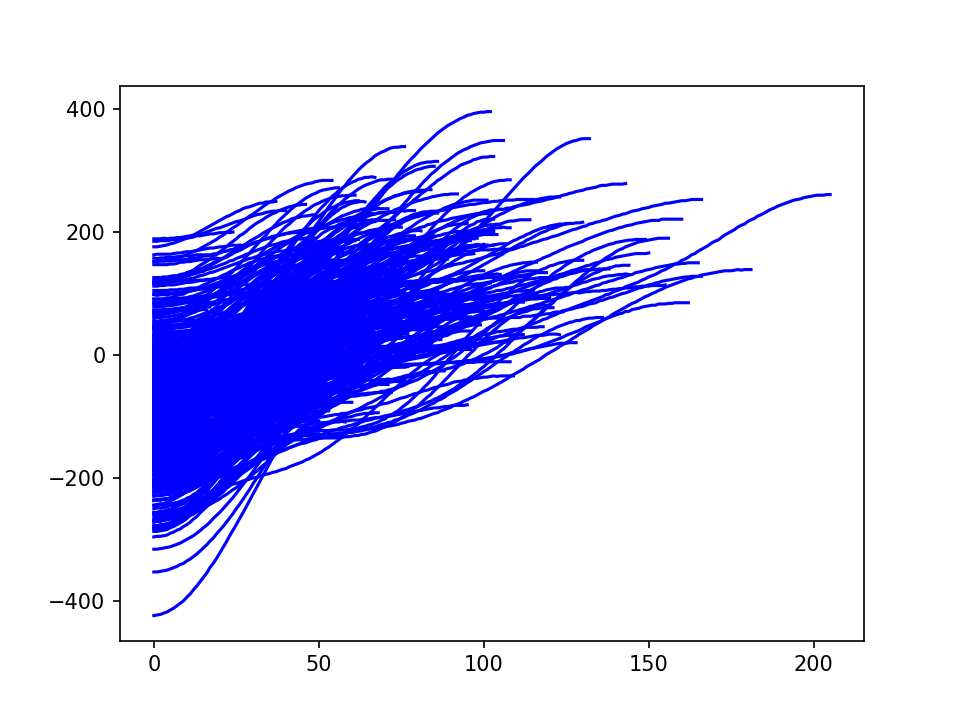

In [115]:
%matplotlib notebook
for k in range(1, 1000):
#     plt.plot([0,l],[0,0],':k')
#     plt.plot(s[mins[k]:maxs[k]+1],'r')
    plt.plot(f[mins[k]:maxs[k]+1],'b')